# CSCI 6380 Data Mining Final Project
By Jae Park (JP)

## Import

In [2]:
import base64
import io

from keras_visualizer import visualizer
import autokeras as ak
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from annoy import AnnoyIndex

from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset
from skmultilearn.ext import Keras
from numpy.random import default_rng

## Plot Configuration

In [3]:
sns.set_context("paper")
sns.set_style("white")
colors = ["#006AFF", "#151E4F", "#EAA814", "#ED692D", "#40C360", "#9163E0"]
sns.set_palette(sns.color_palette(colors))

## Read Data and Pre-process

In [4]:
# Given a base64 encoded image data, decode to 3D numpy array in RGB mode
def decode2array(b64_img):
    decoded = base64.b64decode(b64_img)
    img = Image.open(io.BytesIO(decoded))

    if img.mode == 'RGB':
        return img_to_array(img)

    return img_to_array(img.convert('RGB'))

In [5]:
df = pd.read_csv('korean_webtoons.csv')

### One-Hot Encoding on Genre Variable

In [6]:
# encode genre
ohe_genre = OneHotEncoder()
genre_encoding = ohe_genre.fit_transform(df[['Genre']])
genre_classes = ohe_genre.categories_[0]
df[genre_classes] = genre_encoding.toarray()

In [ ]:
def get_genre(genre_id):
    genre, = ohe_genre.inverse_transform([genre_id])
    return genre[0]

### Nominal Encoding on Authors Variable

In [7]:
le_author = LabelEncoder()
author_encoding = le_author.fit_transform(df['Authors'])
author_classes = le_author.classes_
df['Authors Encoded'] = author_encoding

In [41]:
def get_authors(authors_id):
    authors, = le_author.inverse_transform([authors_id])
    return authors


def get_works_from_author(authors_id):
    authors = get_authors(authors_id)
    return df[df['Authors'] == authors]['Thumbnail'].tolist()

### Thumbnail
Decode thumbnails into 3D numpy arrays. Remove rows with different thumbnail shape.

In [8]:
thumbnail_shape = (101, 125, 3)

thumbnails = df['Thumbnail'].apply(decode2array)
mask = thumbnails.map(np.shape) == thumbnail_shape

thumbnails = np.stack(thumbnails[mask])
df = df[mask]

## Classification

In [9]:
RNG = default_rng()

def verify_model(model, x_train, y_train, n=5):
    indices = RNG.choice(len(x_train), n, replace=False)
    model.fit(x_train[indices], y_train[indices])
    y_pred = model.predict(x_train[indices]).argmax(axis=1)
    y_true = y_train[indices]
    return y_pred, y_true

### Author Classification

In [10]:
x = thumbnails
y = df['Authors Encoded'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y)

x_train_tf = tf.constant(x_train)
x_test_tf = tf.constant(x_test)

In [11]:
author_model = keras.Sequential()
author_model.add(layers.Input(thumbnail_shape))
author_model.add(layers.Normalization())

author_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
author_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
author_model.add(layers.MaxPooling2D((2, 2)))

author_model.add(layers.Dropout(0.25))
author_model.add(layers.Flatten())
author_model.add(layers.Dropout(0.25))

author_model.add(layers.Dense(len(author_classes), activation='softmax'))
author_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
author_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 101, 125, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 99, 123, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 121, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 60, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 60, 64)        0         
                                                                 
 flatten (Flatten)           (None, 184320)            0

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(author_model, to_file='author_model.png', dpi=300, show_shapes=True, show_layer_activations=True)

In [16]:
author_model.fit(x_train_tf, y_train, epochs=5)

Epoch 1/5
43/43 [==============================] - 59s 1s/step - loss: 302.6572 - accuracy: 0.0022
Epoch 2/5
43/43 [==============================] - 59s 1s/step - loss: 4.6448 - accuracy: 0.3863
Epoch 3/5
43/43 [==============================] - 57s 1s/step - loss: 2.2194 - accuracy: 0.6905
Epoch 4/5
43/43 [==============================] - 57s 1s/step - loss: 0.6583 - accuracy: 0.9018
Epoch 5/5
43/43 [==============================] - 56s 1s/step - loss: 0.1902 - accuracy: 0.9719


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred = author_model.predict(x_train).argmax(axis=1)
print(precision_score(y_train, y_pred, average='weighted'))
print(recall_score(y_train, y_pred, average='weighted'))
print(f1_score(y_train, y_pred, average='weighted'))

0.9895494830132939
0.9926144756277696
0.9904288046556567


C:\Users\jp100\anaconda3\envs\FinalProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred = author_model.predict(x_test).argmax(axis=1)
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))

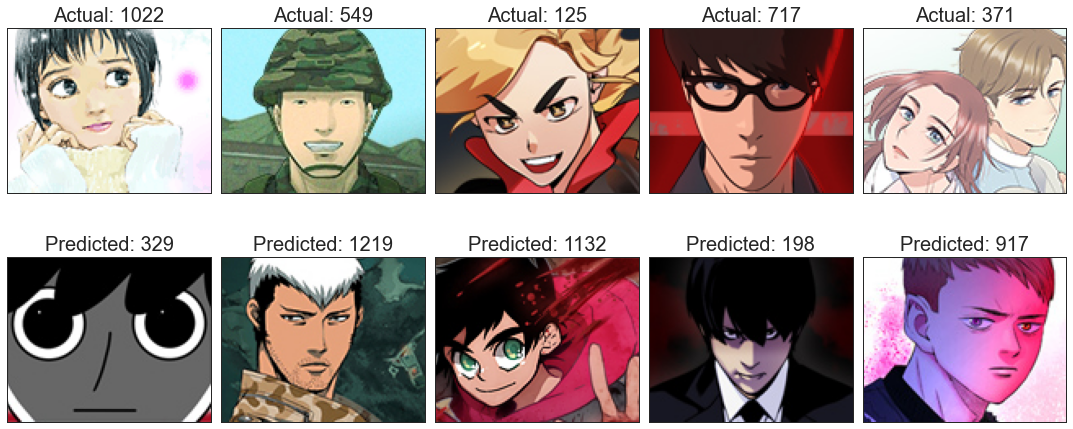

In [44]:
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
for i in range(5):
    ax = axs[0, i]
    ax.imshow(x_test[i].astype(np.uint8))
    ax.set_title(f"Actual: {y_test[i]}", fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axs[1, i]
    works = get_works_from_author(y_pred[i])
    ax.imshow(decode2array(works[0]).astype(np.uint8))
    ax.set_title(f"Predicted: {y_pred[i]}", fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

### Genre Classification

In [45]:
x = thumbnails
y = df[genre_classes].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y)

x_train_tf = tf.constant(x_train)
x_test_tf = tf.constant(x_test)

#### Using Auto Keras

In [46]:
clf = ak.ImageClassifier(overwrite=True, max_trials=2)
history = clf.fit(x_train, y_train, epochs=5)
genre_model = clf.export_model()
genre_model.summary()

Trial 2 Complete [00h 19m 20s]
val_loss: 1.8424464464187622

Best val_loss So Far: 1.8424464464187622
Total elapsed time: 00h 20m 50s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
43/43 [==============================] - 276s 6s/step - loss: 2.6345 - accuracy: 0.2674
Epoch 2/5
43/43 [==============================] - 263s 6s/step - loss: 2.1803 - accuracy: 0.2725
Epoch 3/5
43/43 [==============================] - 273s 6s/step - loss: 2.1620 - accuracy: 0.3028
Epoch 4/5
43/43 [==============================] - 268s 6s/step - loss: 2.0114 - accuracy: 0.2947
Epoch 5/5
43/43 [==============================] - 273s 6s/step - loss: 1.8933 - accuracy: 0.3035
INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 101, 125, 3)]     0         
                                                     

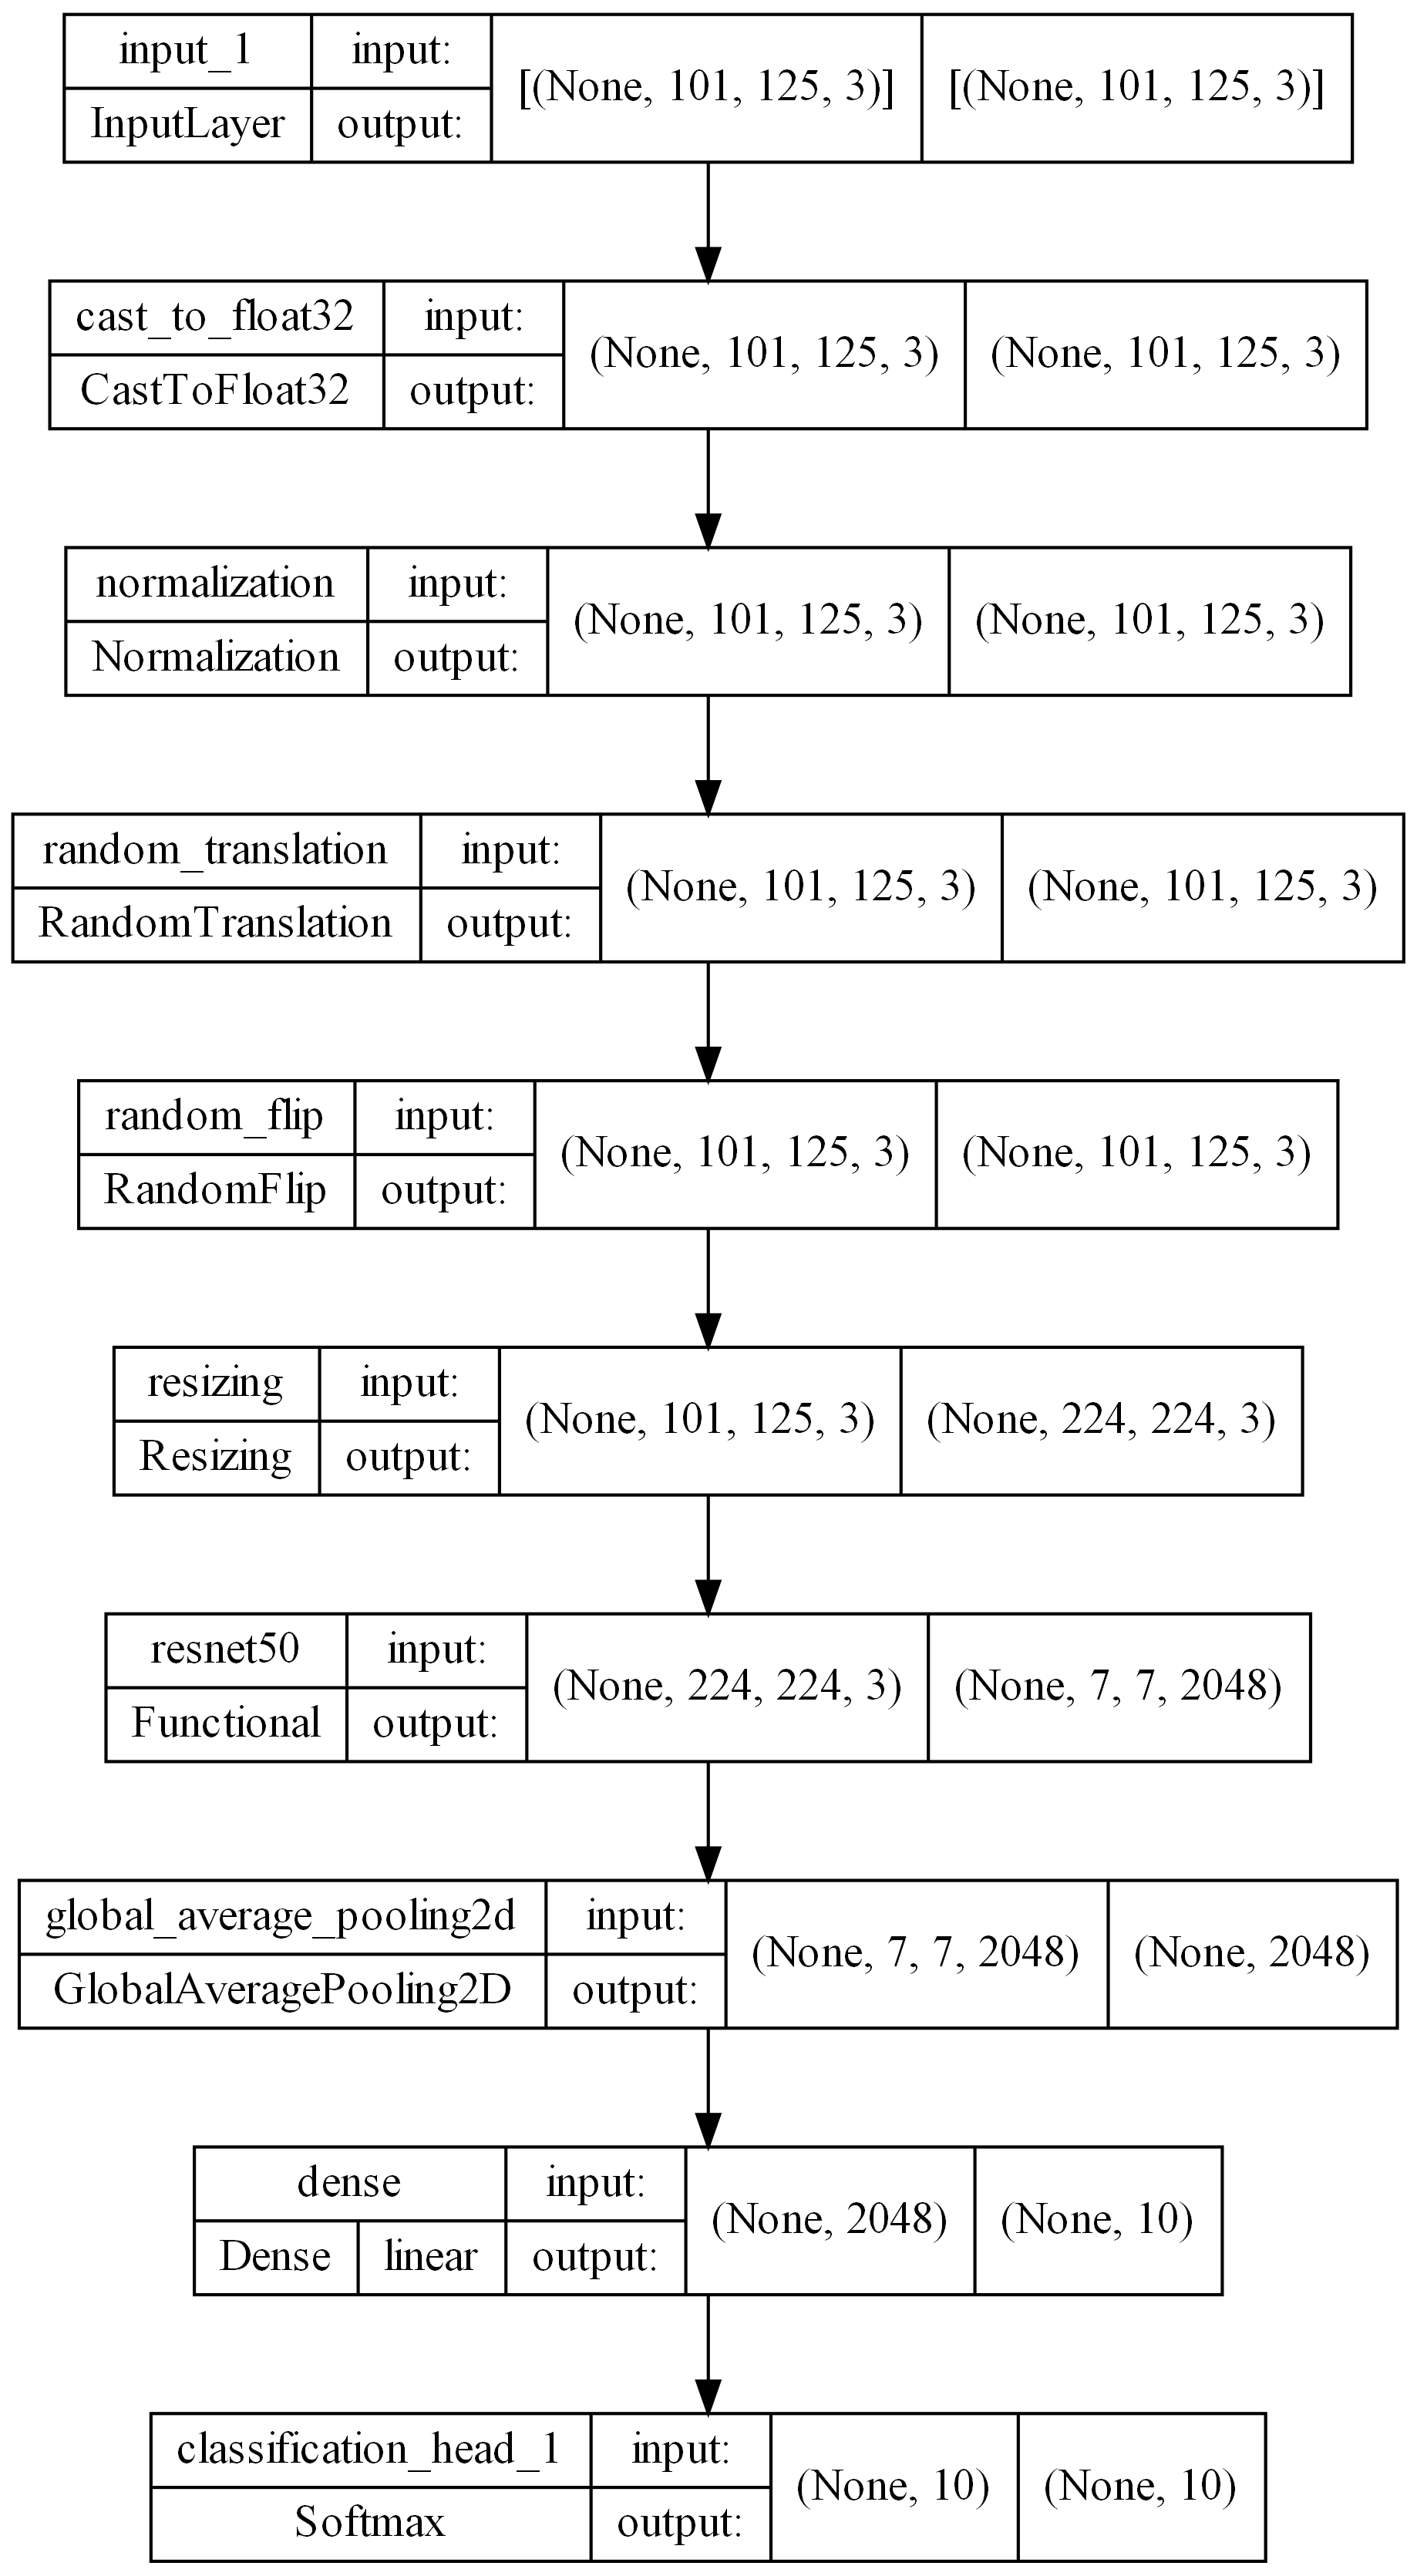

In [47]:
plot_model(genre_model, to_file='genre_model.png', dpi=300, show_shapes=True, show_layer_activations=True)

In [369]:
# genre_model.compile(
#     optimizer=keras.optimizers.Adam(0.0001),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )
# genre_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
43/43 [==============================] - 23s 512ms/step - loss: 9.5453 - accuracy: 0.0030
Epoch 2/5
43/43 [==============================] - 20s 470ms/step - loss: 6.9451 - accuracy: 0.0037
Epoch 3/5
43/43 [==============================] - 21s 500ms/step - loss: 6.9366 - accuracy: 0.0022
Epoch 4/5
43/43 [==============================] - 21s 492ms/step - loss: 6.9247 - accuracy: 0.0022
Epoch 5/5
43/43 [==============================] - 21s 494ms/step - loss: 6.9056 - accuracy: 0.0170


In [48]:
y_pred = genre_model.predict(x_train)

In [51]:
y_pred = y_pred.argmax(axis=1)

In [54]:
y_train.argmax(axis=1)

array([2, 2, 6, ..., 2, 1, 9], dtype=int64)

In [55]:
y_true = y_train.argmax(axis=1)
print(precision_score(y_true, y_pred, average='weighted'))
print(recall_score(y_true, y_pred, average='weighted'))
print(f1_score(y_true, y_pred, average='weighted'))

0.23910255454852375
0.3205317577548006
0.19649075706638588


C:\Users\jp100\anaconda3\envs\FinalProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
y_pred = genre_model.predict(x_test)
y_class = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)
print(precision_score(y_true, y_class, average='weighted'))
print(recall_score(y_true, y_class, average='weighted'))
print(f1_score(y_true, y_class, average='weighted'))

0.2258379965684374
0.28761061946902655
0.17385639582346588


C:\Users\jp100\anaconda3\envs\FinalProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


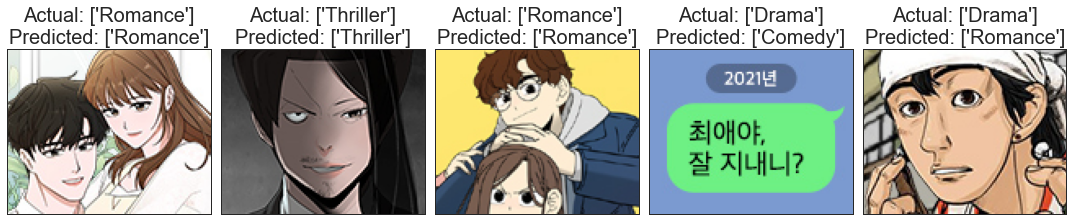

In [80]:
fig, axs = plt.subplots(1, 5, figsize=(15, 7))

for i, j in enumerate(range(5)):
    ax = axs[i]
    ax.imshow(x_test[j].astype(np.uint8))
    ax.set_title(f"Actual: {get_genre(y_test[j])}\nPredicted: {get_genre(y_pred[j])}", fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

## Image Similarity

### Embedding

In [84]:
embedding_model = keras.Sequential()
embedding_model.add(layers.Input(thumbnail_shape))
embedding_model.add(layers.Rescaling(1.0 / 255))
embedding_model.add(genre_model)
embedding_model.add(layers.Normalization(mean=0, variance=1))
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 101, 125, 3)       0         
                                                                 
 model (Functional)          (None, 10)                23608209  
                                                                 
 normalization_1 (Normalizat  (None, 10)               0         
 ion)                                                            
                                                                 
Total params: 23,608,209
Trainable params: 23,555,082
Non-trainable params: 53,127
_________________________________________________________________


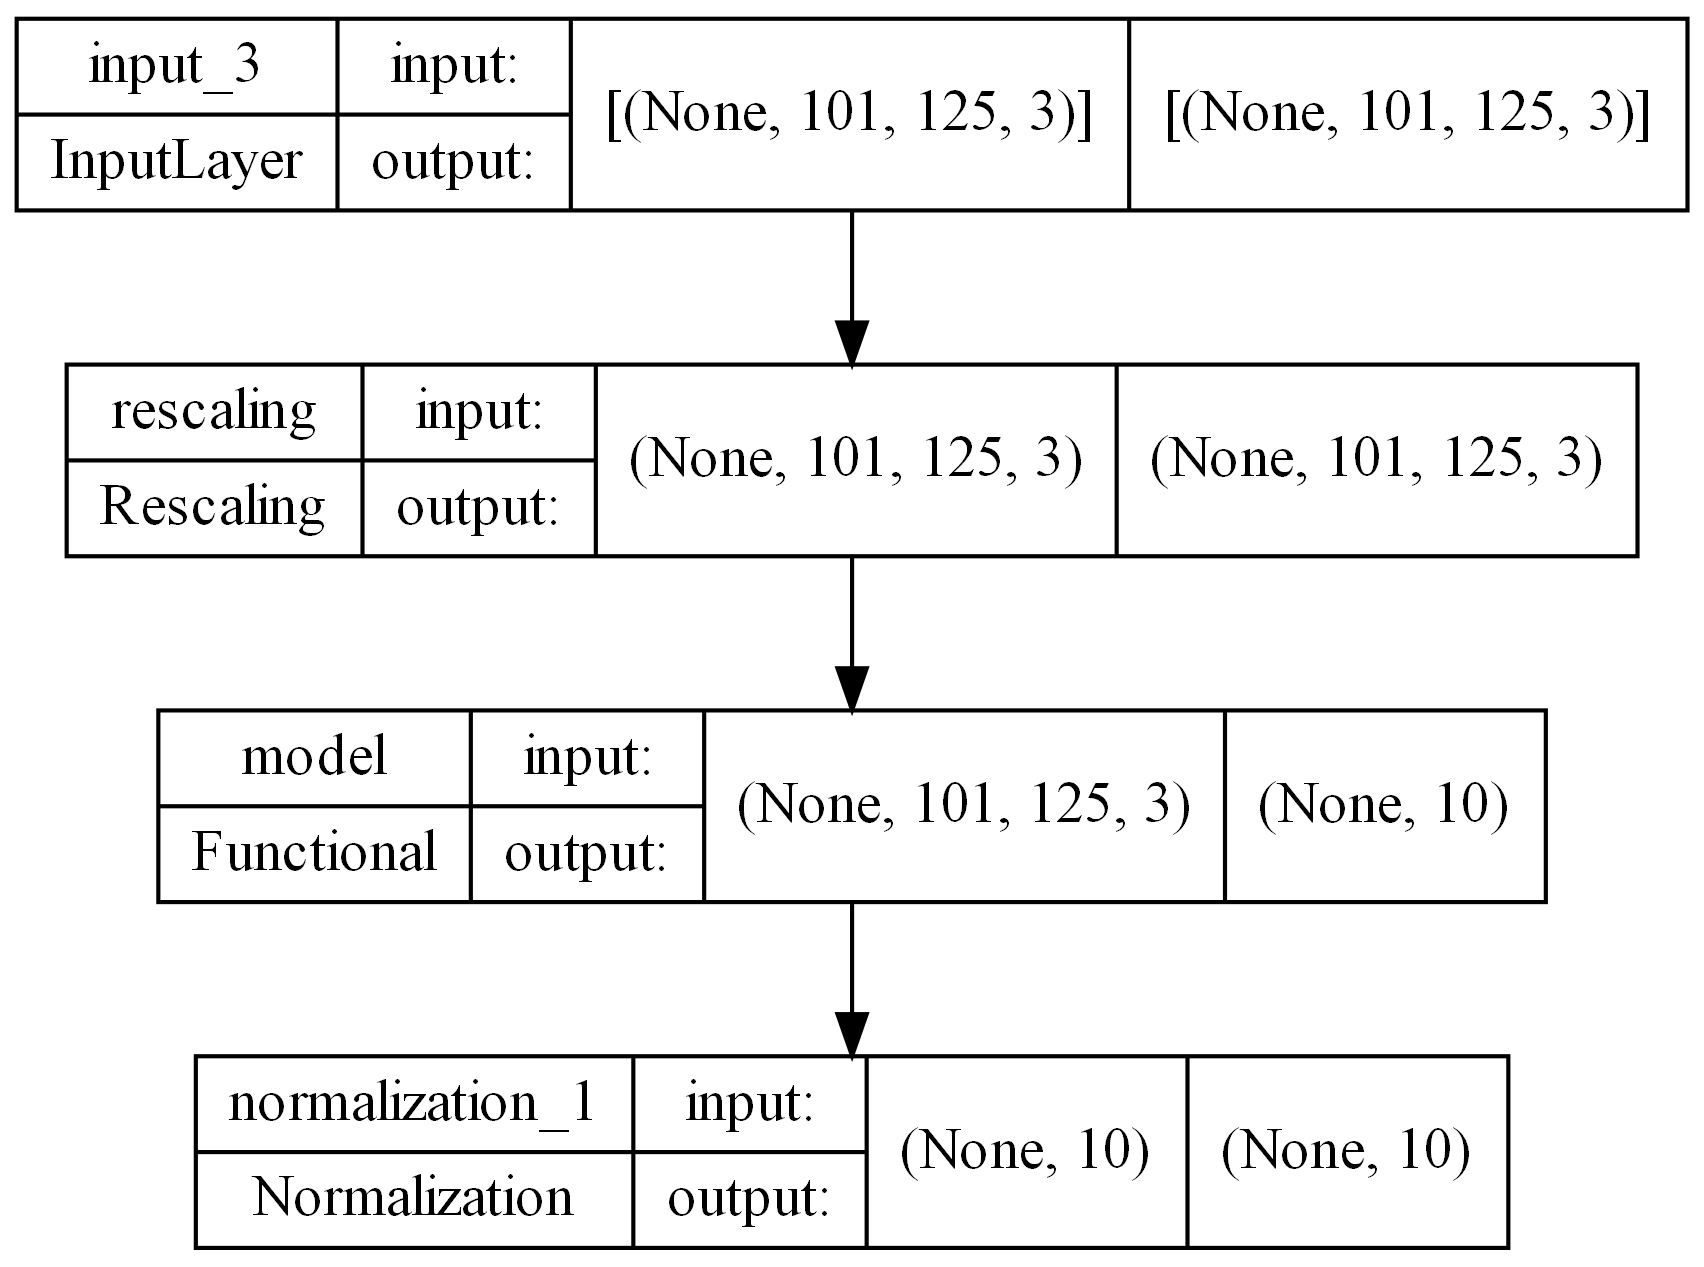

In [87]:
plot_model(embedding_model, to_file='embedding_model.png', dpi=300, show_shapes=True, show_layer_activations=True)

In [86]:
embedding = embedding_model(x)

### Locality Sensitive Hashing and Nearest Neighbors

In [88]:
embedding

<tf.Tensor: shape=(1806, 10), dtype=float32, numpy=
array([[6.96775392e-02, 1.47132045e-02, 1.91948954e-02, ...,
        7.56081077e-04, 1.61645364e-03, 7.84685314e-01],
       [6.35145679e-02, 1.47016458e-02, 1.85014997e-02, ...,
        7.44634366e-04, 1.80365436e-03, 7.91913748e-01],
       [5.11271618e-02, 1.42328115e-02, 1.57367028e-02, ...,
        7.57255359e-04, 2.32307473e-03, 8.03992808e-01],
       ...,
       [7.65549242e-02, 1.49398139e-02, 2.04617120e-02, ...,
        7.55573681e-04, 1.47016579e-03, 7.76770413e-01],
       [7.88954496e-02, 1.51591245e-02, 2.11948119e-02, ...,
        7.40247779e-04, 1.46888453e-03, 7.73685813e-01],
       [5.73866665e-02, 1.45411259e-02, 1.69442538e-02, ...,
        7.47887592e-04, 2.07260624e-03, 7.97083199e-01]], dtype=float32)>

In [117]:
t = AnnoyIndex(10, 'euclidean')
for i in tqdm(range(embedding.shape[0])):
    t.add_item(i, embedding[i])

100%|██████████| 1806/1806 [00:04<00:00, 407.21it/s]


In [118]:
t.build(250)

True

213
[1796, 696, 932, 684, 573, 30, 1116, 733, 305, 1003, 1418, 669, 1312, 1580, 888, 1730, 1303, 143, 1669, 1261, 663, 627, 632, 114, 1792]


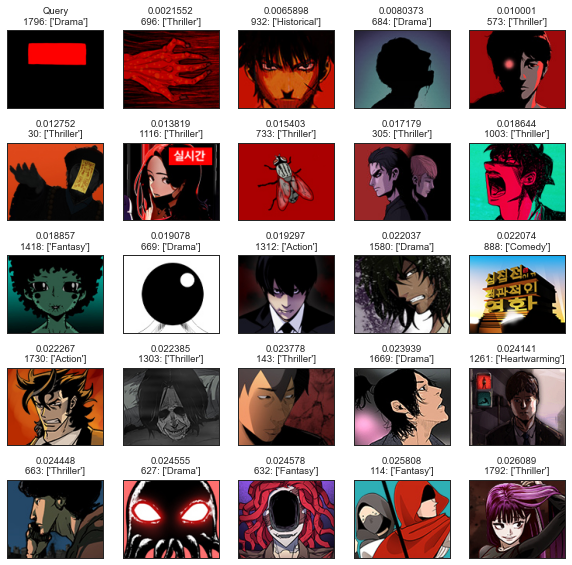

In [122]:
index = RNG.choice(len(x))
ii, dists = t.get_nns_by_item(1796, 25, include_distances=True)

print(index)
print(ii)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for j, (i, dist) in enumerate(zip(ii, dists)):
    r, c = np.unravel_index(j, (5, 5))
    ax = axs[r, c]
    ax.imshow(x[i].astype(np.uint8))
    if j == 0:
        ax.set_title(f"Query\n{i}: {get_genre(y[i])}")
    else:
        ax.set_title(f"{dist:.5}\n{i}: {get_genre(y[i])}")
    ax.set_xticks([])
    ax.set_yticks([])